In [1]:
library(ComplexHeatmap)
library(ggplot2)
library(tidyr)

# set working directory
setwd("/lustre/home/reynaj/Projects/20241011.Byrd_Lab.IBD_NuLisa")

# set data dir
datadir <- "results/aggregated/comp_data/"

# set the outdir
outdir <- "results/aggregated/exploratory_analysis/"

Loading required package: grid

ComplexHeatmap version 2.20.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




## Load the datasets

In [2]:
fn <- file.path(datadir, "protein_levels.npq.tsv")
protein_data <- read.table(fn, header=TRUE, check.names=FALSE, sep = "\t")

fn <- file.path(datadir, "clinical_data.tsv")
clinical_data <- read.table(fn, header=TRUE, sep="\t")
clinical_data$matched_subject_id <- as.character(clinical_data$matched_subject_id) 

# mod the ibd data
clinical_data$ibd_diagnosis <- factor(clinical_data$ibd_diagnosis, 
                                      levels = c("Alamar_Sample_Control", "Control", "CD", "UC", "IBD-U"))
clinical_data$ibd_indicator <- factor(clinical_data$ibd_indicator,
                                      levels = c("Control Super Group", "IBD Super Group"))

# mod the disease activity data
clinical_data$disease_activity <- factor(clinical_data$disease_activity, 
                                         levels = c("N/A", "N/A (Non-IBD Control)",
                                                    "Quiescent", "Mild", "Moderate"))
clinical_data$disease_activity_indicator <- factor(clinical_data$disease_activity_indicator,
                                                   levels=c("In-active Disease", "Active Disease"))

## Check the breakdown by disease subtype then activity

Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


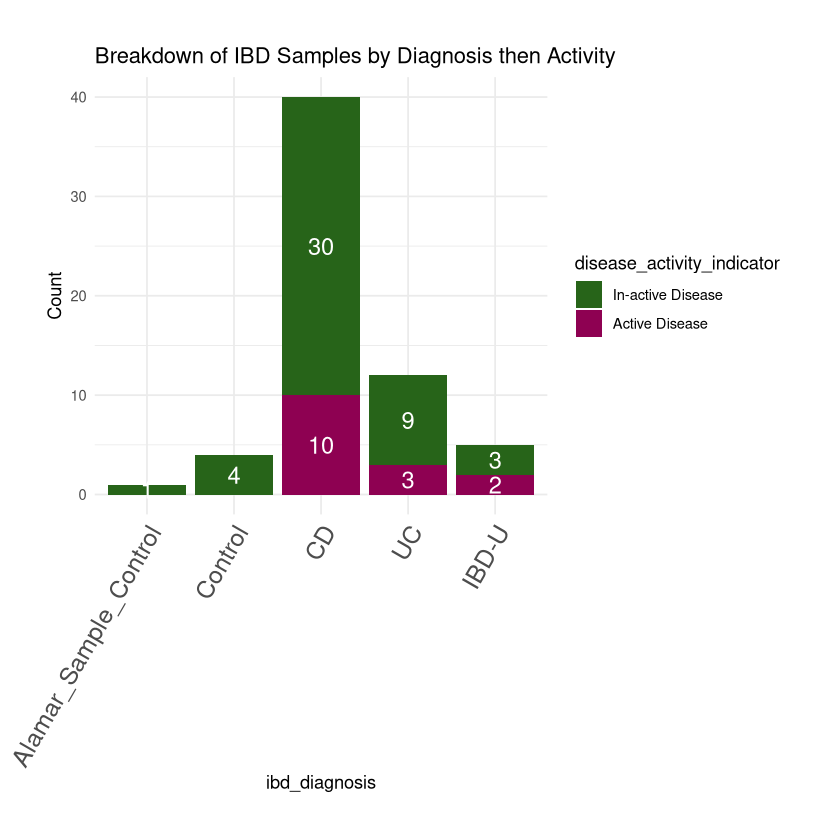

In [3]:
custom_colors <- c(
  
  "N/A" = "#276419",
  "N/A (Non-IBD Control)" = "#4d9221",
  "Quiescent" = "#f1b6da",
  "Mild" = "#c51b7d",
  "Moderate" = "#8e0152",
  
  "Active Disease" = "#8e0152",
  "In-active Disease" = "#276419",
  
  "Alamar_Sample_Control" = "#404040",
  "Control" = "#bababa",
  "CD" = "#d6604d",
  "UC" = "#b2182b",
  "IBD-U" = "#67001f",
  
  "Control Super Group" = "#bababa",
  "IBD Super Group" = "#67001f")


p <- ggplot(clinical_data, aes(x = ibd_diagnosis, fill = disease_activity_indicator)) +
  geom_bar(position = "stack") +
  geom_text(stat = 'count', aes(label = ..count..), 
            position = position_stack(vjust = 0.5), 
            size = 5, color = "white") +  # Adjust size and color here
  labs(title = "Breakdown of IBD Samples by Diagnosis then Activity", 
       x = "ibd_diagnosis", 
       y = "Count") +
  scale_fill_manual(values = custom_colors) +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 60, hjust = 1, size=15), plot.margin = margin(1, 1, 1, 1, "cm"))

fn = file.path(outdir, "samples.breakdown.disease_subtype_then_disease_activity_indicator.png")
ggsave(fn, plot = p, width = 12, height = 8); p



## Check the breakdown by disease subtype or activity

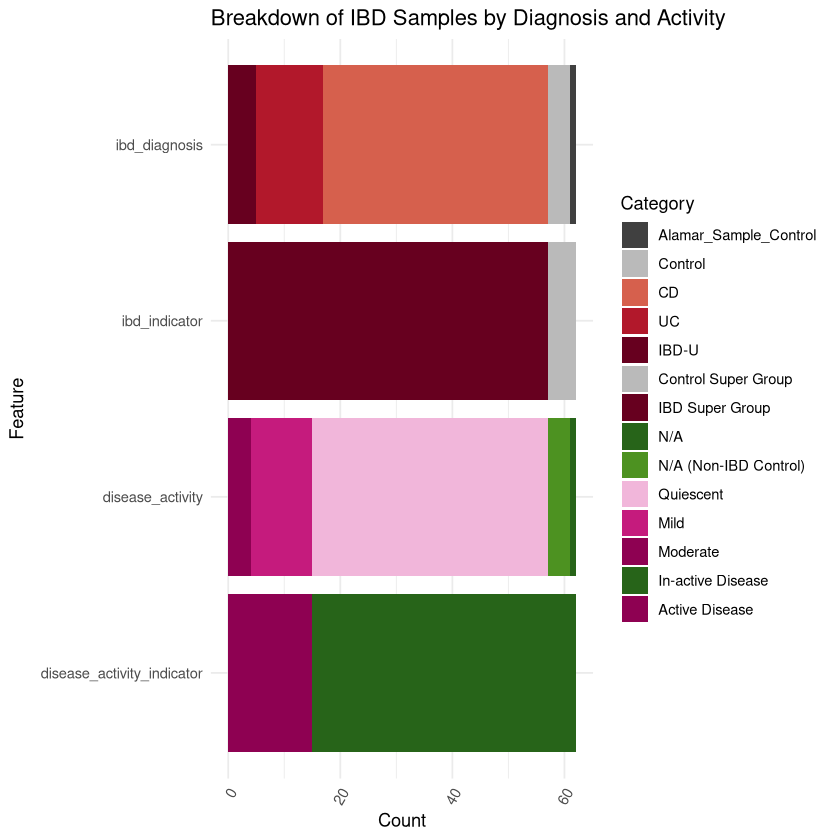

In [4]:
# check identical sample ids
# identical(clinical_data$original_subject_id, colnames(protein_data))

# Transform the data to long format
clinical_long <- clinical_data %>%
  pivot_longer(cols = c("ibd_diagnosis", "ibd_indicator",
                        "disease_activity", "disease_activity_indicator"),
                        names_to = "Feature",
                        values_to = "Category")

# Assuming df_long is your long-format dataframe
clinical_long$Feature <- factor(clinical_long$Feature, 
                                 levels = c(
                                   "disease_activity_indicator",
                                   "disease_activity",
                                   "ibd_indicator",
                                   "ibd_diagnosis"))

# Assuming df_long is your long-format dataframe
clinical_long$Category <- factor(clinical_long$Category, 
                                 levels = c(
                                   "Alamar_Sample_Control", 
                                   "Control", 
                                   "CD", 
                                   "UC", 
                                   "IBD-U", 
                                   "Control Super Group", 
                                   "IBD Super Group",
                                   "N/A", 
                                   "N/A (Non-IBD Control)", 
                                   "Quiescent", 
                                   "Mild", 
                                   "Moderate", 
                                   "In-active Disease",
                                   "Active Disease"))

# Create the stacked barplot with custom colors
p <- ggplot(clinical_long, aes(x = Feature, fill = Category)) +
      geom_bar(position = "stack") +
      labs(title = "Breakdown of IBD Samples by Diagnosis and Activity", x = "Feature", y = "Count") +
      scale_fill_manual(values = custom_colors) +
      theme_minimal() + 
      theme(axis.text.x = element_text(angle = 60, hjust = 1)) + 
      coord_flip()

fn = file.path(outdir, "samples.breakdowns.png")
ggsave(fn, plot = p, width = 8, height = 6); p

## Investigating the variation in protein levels

In [5]:
# column_stds <- apply(protein_data, 1, sd)
# View(as.matrix(column_stds))
# 
# transposed_data <- t(protein_data)
# 
# 
# nzv <- nearZeroVar(transposed_data, saveMetrics = TRUE)
# 
# # Print the rows with near-zero variance
# print(nzv)
# 
# 
# # Rows with near-zero variance
# nzv_rows <- rownames(protein_data)[nzv$nzv]
# 
# # Filter out these rows
# filtered_data <- protein_data[!rownames(protein_data) %in% nzv_rows, ]
# 
# # Print the filtered data
# print(filtered_data)

## Run hierarchical clustering on all samples

gTree[GRID.gTree.705] 

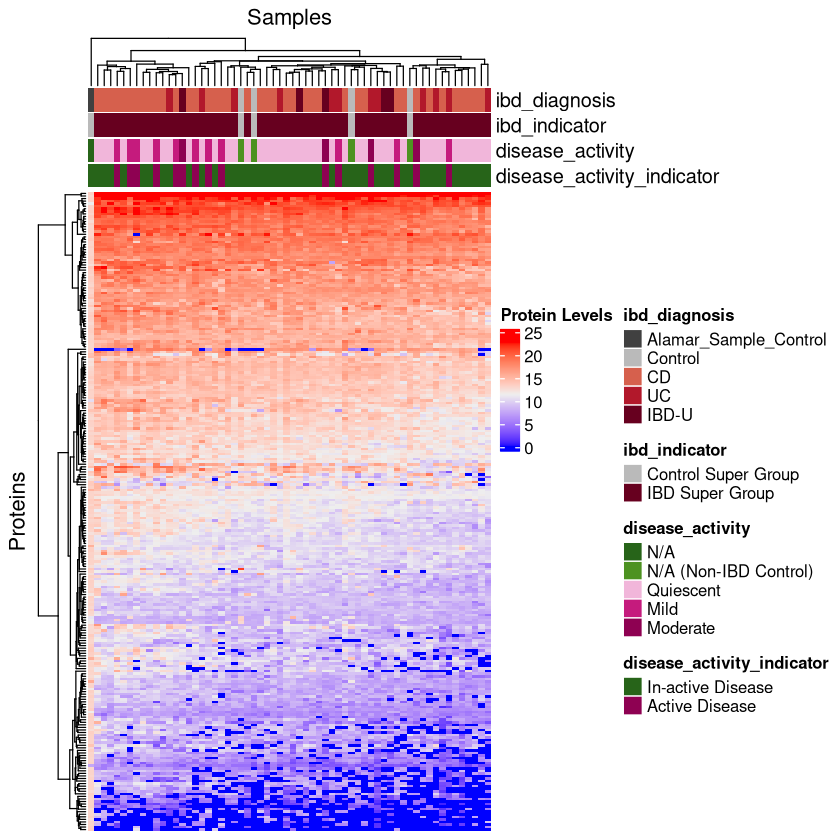

In [6]:
# Create a heatmap annotation for the diagnosis
# color brewer - https://colorbrewer2.org/#type=diverging&scheme=RdGy&n=11
ha_ibd <- HeatmapAnnotation(ibd_diagnosis = clinical_data$ibd_diagnosis,
                        col = list(ibd_diagnosis = c("Alamar_Sample_Control" = "#404040",
                                                     "Control" = "#bababa",
                                                     "CD" = "#d6604d",
                                                     "UC" = "#b2182b",
                                                     "IBD-U" = "#67001f")), which="column")

# Create a heatmap annotation for the diagnosis
ha_ibd_idx <- HeatmapAnnotation(ibd_indicator = clinical_data$ibd_indicator,
                        col = list(ibd_indicator = c("Control Super Group" = "#bababa", "IBD Super Group" = "#67001f")), which="column")

# Create a heatmap annotation for the diagnosis
# color brewer - https://colorbrewer2.org/#type=diverging&scheme=PiYG&n=5
ha_da <- HeatmapAnnotation(disease_activity = clinical_data$disease_activity, 
                        col = list(disease_activity = c("N/A" = "#276419",
                                                        "N/A (Non-IBD Control)" = "#4d9221",
                                                        "Quiescent" = "#f1b6da",
                                                        "Mild" = "#c51b7d",
                                                        "Moderate" = "#8e0152")))

# Create a heatmap annotation for the diagnosis
ha_da_idx <- HeatmapAnnotation(disease_activity_indicator = clinical_data$disease_activity_indicator, 
                        col = list(disease_activity_indicator = c("In-active Disease" = "#276419", "Active Disease" = "#8e0152")))


combined_ha = c(ha_ibd, ha_ibd_idx, ha_da, ha_da_idx) 

ht <- Heatmap(as.matrix(protein_data),
        name = "Protein Levels",
        row_title = "Proteins",
        column_title = "Samples",
        cluster_rows = TRUE,
        cluster_columns = TRUE,
        show_row_names = FALSE,
        show_column_names = FALSE,
        column_labels = clinical_data$ibd_indicator,
        top_annotation = combined_ha)

# Draw the heatmap and add a main title
ht_list <- draw(ht, heatmap_legend_side = "right", 
     annotation_legend_side = "right")

ht_grob <- grid.grabExpr(draw(ht_list))
fn = file.path(outdir, "samples.all_data.hierarchical_clustering.png")
ggsave(fn, plot = ht_grob, width = 8, height = 6); ht_grob;

## Run hierarchical clustering on Crohn's samples only

gTree[GRID.gTree.1124] 

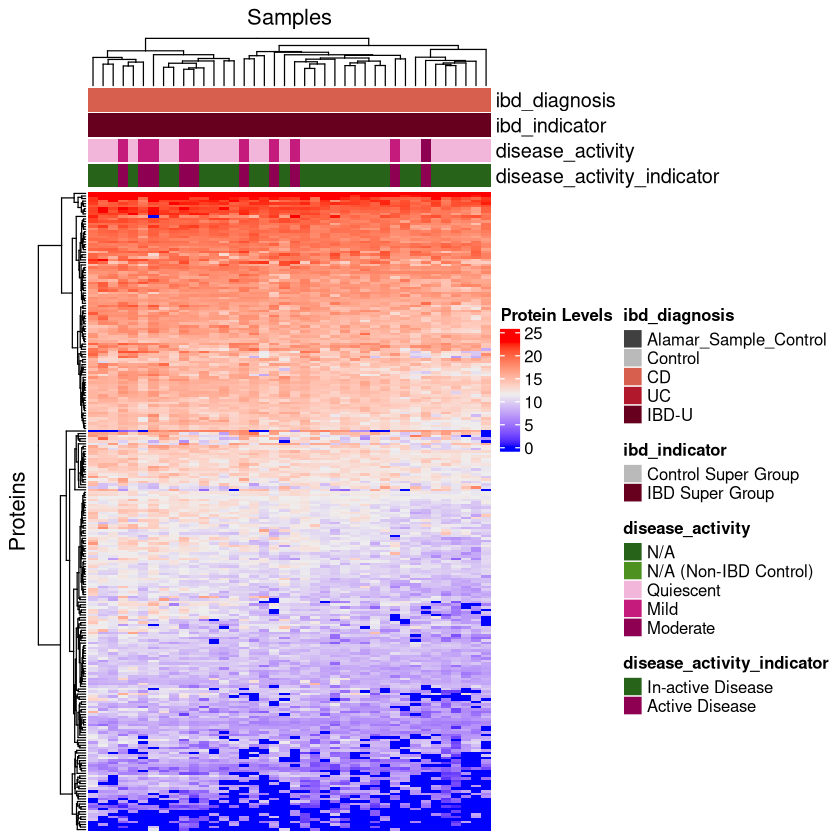

In [7]:
crohn_clinical_data <- clinical_data[clinical_data$ibd_diagnosis == "CD",]
crohn_protein_data <- protein_data[, crohn_clinical_data$matched_subject_id]

clinical_df <- crohn_clinical_data
protein_df <- crohn_protein_data

# Create a heatmap annotation for the diagnosis
# color brewer - https://colorbrewer2.org/#type=diverging&scheme=RdGy&n=11
ha_ibd <- HeatmapAnnotation(ibd_diagnosis = clinical_df$ibd_diagnosis,
                            col = list(ibd_diagnosis = c("Alamar_Sample_Control" = "#404040",
                                                         "Control" = "#bababa",
                                                         "CD" = "#d6604d",
                                                         "UC" = "#b2182b",
                                                         "IBD-U" = "#67001f")), which="column")

# Create a heatmap annotation for the diagnosis
ha_ibd_idx <- HeatmapAnnotation(ibd_indicator = clinical_df$ibd_indicator,
                                col = list(ibd_indicator = c("Control Super Group" = "#bababa", "IBD Super Group" = "#67001f")), which="column")

# Create a heatmap annotation for the diagnosis
# color brewer - https://colorbrewer2.org/#type=diverging&scheme=PiYG&n=5
ha_da <- HeatmapAnnotation(disease_activity = clinical_df$disease_activity, 
                           col = list(disease_activity = c("N/A" = "#276419",
                                                           "N/A (Non-IBD Control)" = "#4d9221",
                                                           "Quiescent" = "#f1b6da",
                                                           "Mild" = "#c51b7d",
                                                           "Moderate" = "#8e0152")))

# Create a heatmap annotation for the diagnosis
ha_da_idx <- HeatmapAnnotation(disease_activity_indicator = clinical_df$disease_activity_indicator, 
                               col = list(disease_activity_indicator = c("In-active Disease" = "#276419", "Active Disease" = "#8e0152")))


combined_ha = c(ha_ibd, ha_ibd_idx, ha_da, ha_da_idx) 

ht <- Heatmap(as.matrix(protein_df),
              name = "Protein Levels",
              row_title = "Proteins",
              column_title = "Samples",
              cluster_rows = TRUE,
              cluster_columns = TRUE,
              show_row_names = FALSE,
              show_column_names = FALSE,
              column_labels = clinical_df$ibd_indicator,
              top_annotation = combined_ha)


# Draw the heatmap and add a main title
ht_list <- draw(ht, heatmap_legend_side = "right", 
                annotation_legend_side = "right")


ht_grob <- grid.grabExpr(draw(ht_list))
fn = file.path(outdir, "samples.crohns_data.hierarchical_clustering.png")
ggsave(fn, plot = ht_grob, width = 8, height = 6); ht_grob;

## Run hierarchical clustering on ulcerative colitis samples only

gTree[GRID.gTree.1543] 

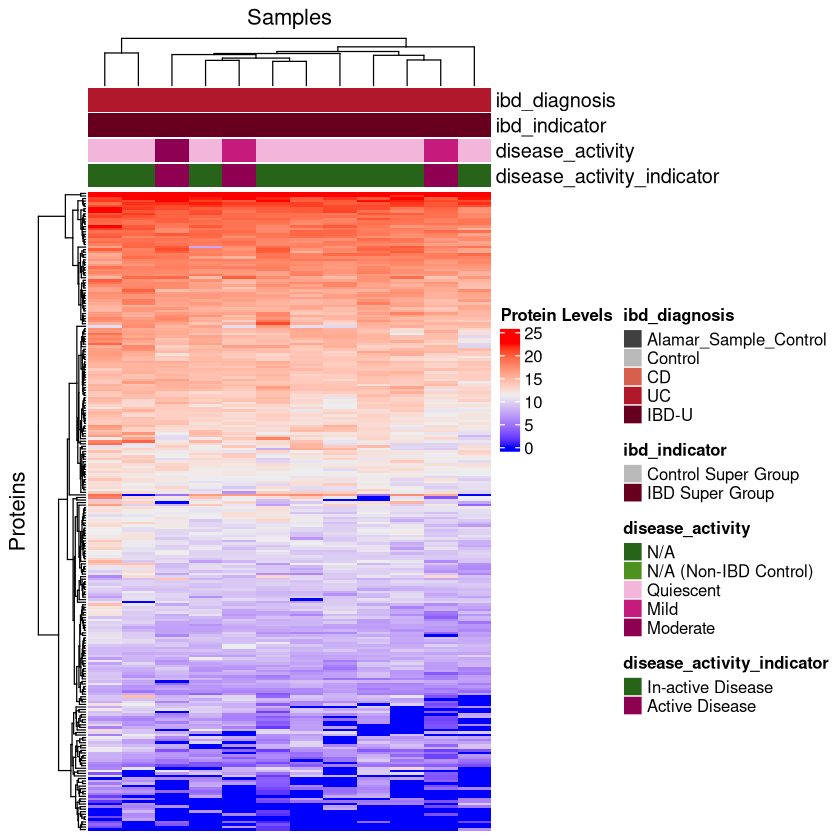

In [8]:
crohn_clinical_data <- clinical_data[clinical_data$ibd_diagnosis == "UC",]
crohn_protein_data <- protein_data[, crohn_clinical_data$matched_subject_id]

clinical_df <- crohn_clinical_data
protein_df <- crohn_protein_data

# Create a heatmap annotation for the diagnosis
# color brewer - https://colorbrewer2.org/#type=diverging&scheme=RdGy&n=11
ha_ibd <- HeatmapAnnotation(ibd_diagnosis = clinical_df$ibd_diagnosis,
                            col = list(ibd_diagnosis = c("Alamar_Sample_Control" = "#404040",
                                                         "Control" = "#bababa",
                                                         "CD" = "#d6604d",
                                                         "UC" = "#b2182b",
                                                         "IBD-U" = "#67001f")), which="column")

# Create a heatmap annotation for the diagnosis
ha_ibd_idx <- HeatmapAnnotation(ibd_indicator = clinical_df$ibd_indicator,
                                col = list(ibd_indicator = c("Control Super Group" = "#bababa", "IBD Super Group" = "#67001f")), which="column")

# Create a heatmap annotation for the diagnosis
# color brewer - https://colorbrewer2.org/#type=diverging&scheme=PiYG&n=5
ha_da <- HeatmapAnnotation(disease_activity = clinical_df$disease_activity, 
                           col = list(disease_activity = c("N/A" = "#276419",
                                                           "N/A (Non-IBD Control)" = "#4d9221",
                                                           "Quiescent" = "#f1b6da",
                                                           "Mild" = "#c51b7d",
                                                           "Moderate" = "#8e0152")))

# Create a heatmap annotation for the diagnosis
ha_da_idx <- HeatmapAnnotation(disease_activity_indicator = clinical_df$disease_activity_indicator, 
                               col = list(disease_activity_indicator = c("In-active Disease" = "#276419", "Active Disease" = "#8e0152")))


combined_ha = c(ha_ibd, ha_ibd_idx, ha_da, ha_da_idx) 

ht <- Heatmap(as.matrix(protein_df),
              name = "Protein Levels",
              row_title = "Proteins",
              column_title = "Samples",
              cluster_rows = TRUE,
              cluster_columns = TRUE,
              show_row_names = FALSE,
              show_column_names = FALSE,
              column_labels = clinical_df$ibd_indicator,
              top_annotation = combined_ha)


# Draw the heatmap and add a main title
ht_list <- draw(ht, heatmap_legend_side = "right", 
                annotation_legend_side = "right")

ht_grob <- grid.grabExpr(draw(ht_list))
fn = file.path(outdir, "samples.ulcerative_colitis_data.hierarchical_clustering.png")
ggsave(fn, plot = ht_grob, width = 8, height = 6); ht_grob;